In [ ]:
import matplotlib.pyplot as plt   
import numpy as np   
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

from keras.layers.core import Dense,Activation,Dropout
from keras.layers import LSTM 
from keras.models import Sequential

In [ ]:
data = pd.read_csv('stock1.csv')
data = data[['Open','High','Low','Volume','Close']]
data.head()

In [ ]:
sequence_length = 21
n_features = len(data.columns)
val_ratio = 0.1
n_epochs = 300
batch_size = 512

In [ ]:
data = data.iloc[:,:].values
data_processed = []
for index in range(len(data)-sequence_length):
    data_processed.append(data[index:index+sequence_length])
data_processed = np.array(data_processed)

In [ ]:
val_split  = round((1-val_ratio)*data_processed.shape[0])
train = data_processed[:int(val_split),:]
val = data_processed[int(val_split):,:]
print('Training data:{}'.format(train.shape))
print('vali data:{}'.format(val.shape))

In [ ]:
train_samples, train_nx, train_ny = train.shape
val_samples, val_nx, val_ny = val.shape

train = train.reshape((train_samples, train_nx * train_ny))
val = val.reshape((val_samples, val_nx * val_ny))

preprocessor = MinMaxScaler().fit(train)
train = preprocessor.transform(train)
val = preprocessor.transform(val)

train = train.reshape((train_samples, train_nx, train_ny))
val = val.reshape((val_samples, val_nx, val_ny))

In [ ]:
X_train = train[:, : -1]
y_train = train[:, -1][: ,-1]
X_val = val[:, : -1]
y_val = val[:, -1][ : ,-1]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], n_features))

In [9]:
model = Sequential([
    LSTM(input_shape=(X_train.shape[1:]),units = 128,return_sequences=True),
    Dropout(0.5),
    LSTM(128,return_sequences=False),
    Dropout(0.25),
    Dense(units=1),
    Activation('linear')
    
])
model.compile(loss="mse",optimizer="adam")
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs=n_epochs,
    verbose=2
)

2/2 - 0s - loss: 0.0034 - 352ms/epoch - 176ms/step
Epoch 60/300
2/2 - 0s - loss: 0.0036 - 354ms/epoch - 177ms/step
Epoch 61/300
2/2 - 0s - loss: 0.0037 - 472ms/epoch - 236ms/step
Epoch 62/300
2/2 - 0s - loss: 0.0034 - 340ms/epoch - 170ms/step
Epoch 63/300
2/2 - 0s - loss: 0.0036 - 310ms/epoch - 155ms/step
Epoch 64/300
2/2 - 0s - loss: 0.0037 - 306ms/epoch - 153ms/step
Epoch 65/300
2/2 - 0s - loss: 0.0031 - 308ms/epoch - 154ms/step
Epoch 66/300
2/2 - 0s - loss: 0.0030 - 302ms/epoch - 151ms/step
Epoch 67/300
2/2 - 0s - loss: 0.0033 - 321ms/epoch - 161ms/step
Epoch 68/300
2/2 - 0s - loss: 0.0037 - 305ms/epoch - 153ms/step
Epoch 69/300
2/2 - 0s - loss: 0.0037 - 308ms/epoch - 154ms/step
Epoch 70/300
2/2 - 0s - loss: 0.0034 - 291ms/epoch - 146ms/step
Epoch 71/300
2/2 - 0s - loss: 0.0035 - 310ms/epoch - 155ms/step
Epoch 72/300
2/2 - 0s - loss: 0.0030 - 301ms/epoch - 150ms/step
Epoch 73/300
2/2 - 0s - loss: 0.0036 - 309ms/epoch - 155ms/step
Epoch 74/300
2/2 - 0s - loss: 0.0035 - 356ms/epoch - 

In [10]:
preds_val = model.predict(X_val)
diff = []
for i in range(len(y_val)):
    pred = preds_val[i][0]
    diff.append(y_val[i] - pred)

2023-05-16 22:42:38.854861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 22:42:38.856992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 22:42:38.858592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 13ms/step


In [11]:
real_min = preprocessor.data_min_[104]
real_max = preprocessor.data_max_[104]
print(preprocessor.data_min_[104])
print(preprocessor.data_max_[104])

preds_real = preds_val * (real_max - real_min) + real_min
y_val_real = y_val * (real_max - real_min) + real_min

6860.669922
16057.44043


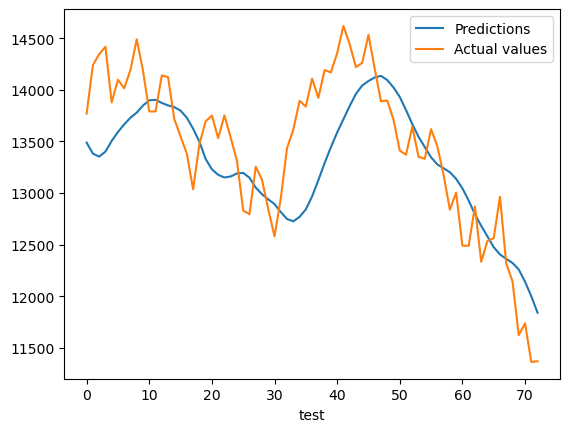

In [12]:
plt.plot(preds_real, label='Predictions')
plt.plot(y_val_real, label='Actual values')
plt.xlabel('test')
plt.legend(loc=0)
plt.show()